In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-emails-data-csv/spam_Emails_data.csv
/kaggle/input/electra/transformers/default/1/config.json
/kaggle/input/electra/transformers/default/1/tokenizer_config.json
/kaggle/input/electra/transformers/default/1/pytorch_model.bin
/kaggle/input/electra/transformers/default/1/vocab.txt


In [2]:
#  Install Required Libraries
!pip install transformers
!pip install tqdm
!pip install torch
!pip install datasets
!pip install transformers datasets scikit-learn
!pip install -q transformers datasets scikit-learn matplotlib seaborn
!pip install pandas matplotlib scikit-learn gensim



In [3]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download('zoniaimran/spam-emails-data-csv')




In [3]:
#  regular imports 
import os, re, string, random, time
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import torch
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from datasets import Dataset
from transformers import TrainerCallback
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments)

from gensim.models import FastText
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, classification_report,
                             confusion_matrix)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE   # optional, for imbalance
tqdm.pandas()  # progress bars


In [4]:
random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'

In [5]:
# Step 1 data load
# Load the dataset
import pandas as pd

# Load the CSV file into the 'data' variable
data = pd.read_csv('/kaggle/input/spam-emails-data-csv/spam_Emails_data.csv')

# Show the first few rows
data.head()
 





,label,text
0,Spam,viiiiiiagraaaa\nonly for the ones that want to...
1,Ham,got ice thought look az original message ice o...
2,Spam,yo ur wom an ne eds an escapenumber in ch ma n...
3,Spam,start increasing your odds of success & live s...
4,Ham,author jra date escapenumber escapenumber esca...


In [6]:
# Step 2: Preprocessing  Load the CSV file 
file_path = '/kaggle/input/spam-emails-data-csv/spam_Emails_data.csv'

try:
    data = pd.read_csv(file_path, sep=',', on_bad_lines='skip', engine='python', encoding='utf-8')
except Exception as e:
    print("Error reading the CSV file:", e)
    raise

# Display total emails
total_emails = len(data)
print(f"Total number of emails in the dataset: {total_emails}")

#  Drop rows with missing 'text' column
if 'text' not in data.columns:
    raise ValueError("'text' column not found in dataset.")
data = data.dropna(subset=['text'])

# Preprocessing function
def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove non-letters
    text = re.sub(r"\s+", " ", text)         # Normalize whitespace
    text = text.strip().lower()              # Trim and lowercase
    return text

#  Apply preprocessing
data['cleaned_text'] = data['text'].astype(str).apply(preprocess_text)

#  Drop empty cleaned texts
data = data[data['cleaned_text'].str.strip() != ""]

#  Tokenize the cleaned text
data['tokenized_text'] = data['cleaned_text'].apply(lambda x: x.split())

#  Show count after preprocessing
preprocessed_emails = len(data)
print(f"Number of emails after preprocessing: {preprocessed_emails}")

Total number of emails in the dataset: 195089
Number of emails after preprocessing: 194176


In [7]:
data['tokenized_text'] = data['cleaned_text'].apply(lambda x: x.split())
# Tokenize cleaned text if not already present
if 'tokenized_text' not in data.columns:
    data['tokenized_text'] = data['cleaned_text'].apply(lambda x: x.split())




Training FastText model …
FastText training completed.


  0%|          | 0/194176 [00:00<?, ?it/s]

Feature matrix shape: (194176, 20)


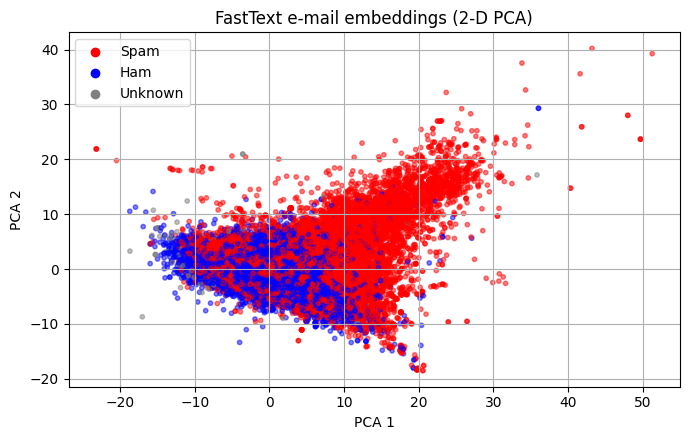

In [8]:
# Step 3 : Apply Fast Text Embedding  

#  Train FastText 

print("Training FastText model …")
fasttext_model = FastText(
        sentences   = data["tokenized_text"].tolist(),
        vector_size = 20,
        window      = 5,
        min_count   = 2,
        sg          = 0,
        workers     = 4,
        epochs      = 5,
        seed        = 42
)

print("FastText training completed.")

#  Build embeddings matrix
def email_embedding(tokens):
    vecs = [fasttext_model.wv[w] for w in tokens if w in fasttext_model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(fasttext_model.vector_size)

data["embedding"] = data["tokenized_text"].progress_apply(email_embedding)
X = np.vstack(data["embedding"].values)
print("Feature matrix shape:", X.shape)

#  2-D PCA plot 
pca  = PCA(n_components=2, random_state=42)
X2d  = pca.fit_transform(X)

color_map = {"spam": "red", "ham": "blue"}
data["color"] = data["label"].str.lower().map(color_map).fillna("gray")

plt.figure(figsize=(7,4.5))
plt.scatter(X2d[:,0], X2d[:,1], c=data["color"], s=10, alpha=0.5)
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.title("FastText e-mail embeddings (2-D PCA)")
for lab, clr in color_map.items():
    plt.scatter([],[], c=clr, label=lab.capitalize())
plt.scatter([],[], c="gray", label="Unknown")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
!nvidia-smi


Fri May 16 19:44:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
# step 4 : Feature selection through XGBOOST 

#  basic label prep 

data = data.dropna(subset=['label'])
data['label'] = data['label'].str.lower()
data = data[data['label'].isin(['ham', 'spam'])]         # keep only ham/spam rows
y = data['label'].map({'ham': 0, 'spam': 1})

# feature matrix from FastText embeddings 
X = np.vstack(data['embedding'].values)

print(f"Total Emails: {X.shape[0]}")
print(f"Initial Features: {X.shape[1]}")


#  Train baseline XGBoost 

xgb_model = XGBClassifier(
    n_estimators     = 100,
    max_depth        = 5,
    learning_rate    = 0.1,
    subsample        = 0.8,
    eval_metric      = 'logloss',
    use_label_encoder=False,
    random_state     = 42
)
xgb_model.fit(X, y)



# select features whose importance ≥ mean 

selector = SelectFromModel(xgb_model, threshold='mean', prefit=True)
X_sel = selector.transform(X)

print(f"Features Selected by XGBoost: {X_sel.shape[1]} out of {X.shape[1]}")

#  train‑test split & save 

X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y, test_size=0.20, random_state=42, stratify=y
)
print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}")

np.save('/kaggle/working/X1_train.npy', X_train)
np.save('/kaggle/working/X1_test.npy',  X_test)
np.save('/kaggle/working/y1_train.npy', y_train)
np.save('/kaggle/working/y1_test.npy',  y_test)

print("Feature selection and train-test split complete. Data saved.")

Total Emails: 193722
Initial Features: 20
Features Selected by XGBoost: 8 out of 20
Training Data: (154977, 8), Testing Data: (38745, 8)
Feature selection and train-test split complete. Data saved.


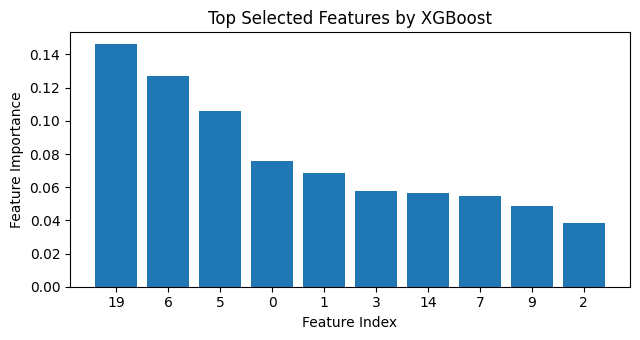

In [10]:
# STEP 5 : Show XGBoost Result in Plot

# Get feature importance scores
feature_importance = xgb_model.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importance)[::-1]

# Plot
plt.figure(figsize=(6.5, 3.5))  # Reduced size from (10, 5)
plt.bar(range(len(sorted_idx[:10])), feature_importance[sorted_idx[:10]], align="center")
plt.xticks(range(len(sorted_idx[:10])), sorted_idx[:10])
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.title("Top Selected Features by XGBoost")
plt.tight_layout()
plt.show()


In [11]:
import torch
from transformers import AutoModelForSequenceClassification

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:

import os
os.environ["WANDB_DISABLED"] = "true"


Map:   0%|          | 0/154977 [00:00<?, ? examples/s]

Map:   0%|          | 0/38745 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/electra/transformers/default/1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.221700,0.195328,0.920661,0.916648,0.915448,0.916048
2,0.188900,0.173891,0.932662,0.921545,0.937391,0.929401
3,0.156800,0.158041,0.937824,0.933283,0.935371,0.934326


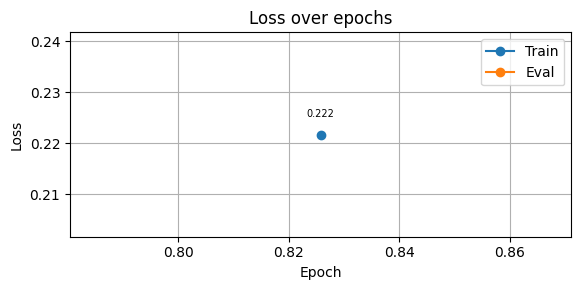

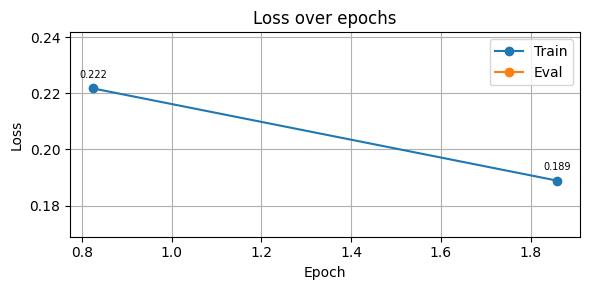

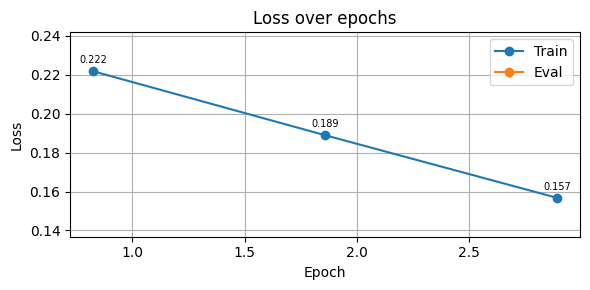


Classification Report:

              precision    recall  f1-score       support
Not-Spam       0.941915  0.940024  0.940969  20425.000000
Spam           0.933283  0.935371  0.934326  18320.000000
accuracy       0.937824  0.937824  0.937824      0.937824
macro avg      0.937599  0.937698  0.937647  38745.000000
weighted avg   0.937833  0.937824  0.937828  38745.000000


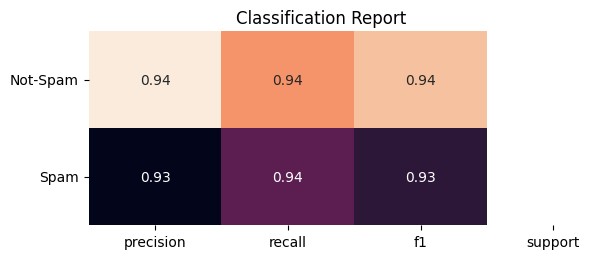

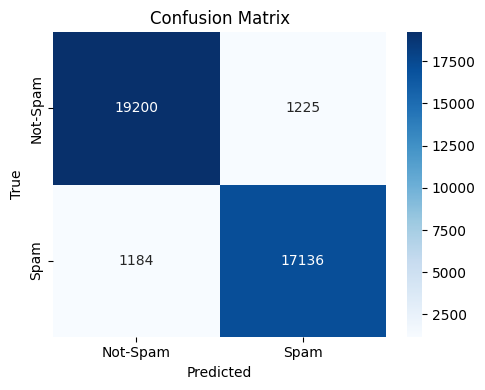

In [13]:
# Step 6 : Train ELECTRA


# Set seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Load data
X_train = np.load("/kaggle/working/X1_train.npy", allow_pickle=True)
X_test  = np.load("/kaggle/working/X1_test.npy",  allow_pickle=True)
y_train = np.load("/kaggle/working/y1_train.npy", allow_pickle=True)
y_test  = np.load("/kaggle/working/y1_test.npy",  allow_pickle=True)

X_train = list(map(str, X_train))
X_test  = list(map(str, X_test))

# Tokenizer & dataset
model_path = "/kaggle/input/electra/transformers/default/1"
tokenizer = AutoTokenizer.from_pretrained(model_path)

MAX_LEN = 64
def tokenize(batch):
    return tokenizer(batch["text"],
                     truncation=True,
                     padding="max_length",
                     max_length=MAX_LEN)

train_data = Dataset.from_dict({"text": X_train, "label": y_train.tolist()})
test_data  = Dataset.from_dict({"text": X_test,  "label": y_test.tolist()})

train_data = train_data.map(tokenize, batched=True)
test_data  = test_data.map(tokenize,  batched=True)

train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch",  columns=["input_ids", "attention_mask", "label"])

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    model_path, num_labels=2).to(device)

# Plotting callback
train_losses, eval_losses, epochs = [], [], []
class PlotCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        if not state.log_history:
            return
        log = state.log_history[-1]
        epoch, tr_loss, ev_loss = log.get("epoch"), log.get("loss"), log.get("eval_loss")

        if epoch is None:
            return

        epochs.append(epoch)
        train_losses.append(tr_loss)
        eval_losses.append(ev_loss)

        plt.figure(figsize=(6,3))
        plt.plot(epochs, train_losses, marker='o', label="Train")
        plt.plot(epochs, eval_losses, marker='o', label="Eval")

        for i, v in enumerate(train_losses):
            if v is not None:
                plt.text(epochs[i], v + 0.003, f"{v:.3f}", fontsize=7,
                         ha="center", va="bottom")
        for i, v in enumerate(eval_losses):
            if v is not None:
                plt.text(epochs[i], v - 0.006, f"{v:.3f}", fontsize=7,
                         ha="center", va="top")

        valid = [v for v in train_losses + eval_losses if v is not None]
        plt.ylim(min(valid) - 0.02, max(valid) + 0.02)

        plt.title("Loss over epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Training Arguments (NO load_best_model_at_end)
training_args = TrainingArguments(
    output_dir                  = "./results",
    num_train_epochs            = 3,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size  = 64,
    evaluation_strategy         = "epoch",
    save_strategy               = "epoch",
    save_total_limit            = 1,
    learning_rate               = 5e-5,
    weight_decay                = 0.01,
     warmup_ratio = 0.1 ,
    logging_dir                 = "./logs",
    report_to                   = "none",
    fp16                        = True,
    seed                        = SEED,
    gradient_accumulation_steps= 2
)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy":  accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, zero_division=0),
        "recall":    recall_score(labels, preds, zero_division=0),
        "f1":        f1_score(labels, preds, zero_division=0),
    }

# Trainer
trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_data,
    eval_dataset    = test_data,
    compute_metrics = compute_metrics,
    callbacks       = [PlotCallback()]
)

# Train
trainer.train()

# Evaluation
preds = trainer.predict(test_data)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

print("\nClassification Report:\n")
rep_df = pd.DataFrame(
    classification_report(y_true, y_pred,
                          target_names=["Not-Spam","Spam"],
                          output_dict=True)
).transpose()
print(rep_df)

plt.figure(figsize=(6,2.7))
sns.heatmap(rep_df.iloc[:2,:-1], annot=True, fmt=".2f", cbar=False,
            xticklabels=["precision","recall","f1","support"])
plt.title("Classification Report")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not-Spam","Spam"],
            yticklabels=["Not-Spam","Spam"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [14]:
import os

for root, dirs, files in os.walk('/kaggle/input/xlnet/pytorch/xlnet-base-case/1'):
    print("Directory:", root)
    for file in files:
        print("   File:", file)
        



Directory: /kaggle/input/xlnet/pytorch/xlnet-base-case/1
   File: config.json
   File: tokenizer.json
   File: pytorch_model.bin


In [15]:
#  Step 7 : Train XLNET            

# === Load Dataset ===
X_train = np.load("/kaggle/working/X_train.npy", allow_pickle=True)
X_test = np.load("/kaggle/working/X_test.npy", allow_pickle=True)
y_train = np.load("/kaggle/working/y_train.npy", allow_pickle=True)
y_test = np.load("/kaggle/working/y_test.npy", allow_pickle=True)

X_train = list(map(str, X_train))
X_test = list(map(str, X_test))

# === Tokenizer & Dataset ===
model_path = 'xlnet-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_path)

def tokenize(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=128)

train_data = Dataset.from_dict({"text": X_train, "label": y_train.tolist()})
test_data = Dataset.from_dict({"text": X_test, "label": y_test.tolist()})

train_data = train_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# === Load Model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2).to(device)

# === PlotCallback (Same as Electra) ===
train_losses = []
eval_losses = []
epochs = []

class PlotCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        log_history = state.log_history[-1]
        epoch = log_history.get("epoch")
        train_loss = log_history.get("loss", None)
        eval_loss = log_history.get("eval_loss", None)

        if epoch:
            epochs.append(epoch)
            train_losses.append(train_loss)
            eval_losses.append(eval_loss)

            plt.figure(figsize=(6, 3))
            plt.plot(epochs, train_losses, label='Train Loss', marker='o', linewidth=2)
            plt.plot(epochs, eval_losses, label='Eval Loss', marker='o', linewidth=2)

            for i, txt in enumerate(train_losses):
                if txt is not None:
                    plt.text(epochs[i], train_losses[i], f"{train_losses[i]:.3f}", fontsize=8, ha='right')
            for i, txt in enumerate(eval_losses):
                if txt is not None:
                    plt.text(epochs[i], eval_losses[i], f"{eval_losses[i]:.3f}", fontsize=8, ha='left')

            plt.title("Loss over Epochs")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

# === Training Arguments (Electra-style) ===
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir="./logs",
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    fp16=True                      #  Fast mixed precision training
)

# === Compute Metrics ===
def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, zero_division=0),
        "recall": recall_score(labels, preds, zero_division=0),
        "f1": f1_score(labels, preds, zero_division=0)
    }

# === Trainer ===
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics,
    callbacks=[PlotCallback()]
)

# === Train ===
trainer.train()

# === Final Evaluation ===
predictions = trainer.predict(test_data)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# === Classification Report ===
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Not Spam", "Spam"]))

# === Confusion Matrix ===
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Spam", "Spam"],
            yticklabels=["Not Spam", "Spam"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like xlnet-base-cased is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [ ]:

# Step 5 Train LSTM model with improved architecture

# Load Preprocessed Dataset (Feature Selected)
X_train = np.load("/kaggle/working/X_train.npy")
X_test = np.load("/kaggle/working/X_test.npy")
y_train = np.load("/kaggle/working/y_train.npy")
y_test = np.load("/kaggle/working/y_test.npy")

# Print Dataset Shapes
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

# Reshape Data for LSTM (Adding Time Step Dimension)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # (samples, timesteps, features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define LSTM Model with more units and better architecture
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # Increased units
    BatchNormalization(),
    Dropout(0.3),  # Lower dropout to retain more information
    LSTM(256, return_sequences=True),  # Added another LSTM layer for better learning
    BatchNormalization(),
    LSTM(128),  # Reduce to 128 units after multiple layers for efficiency
    Dropout(0.3),
    Dense(256, activation='relu'),  # Increased Dense layer units
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Binary Classification (Spam/Ham)
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train LSTM Model with a learning rate scheduler
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

# Train the model for more epochs and validation
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[reduce_lr])

# Predict on Test Set
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Convert Probabilities to 0/1

# Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print Evaluation Metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")


